In [1]:
import librosa
import numpy as np

from transformers import WhisperFeatureExtractor

import matplotlib.pyplot as plt

/Users/sanchitgandhi/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define Whisper feature extraction constants, from https://github.com/huggingface/transformers/blob/f7329751fe5c43365751951502c00df5a4654359/src/transformers/models/whisper/feature_extraction_whisper.py#L62
hop_length = 160
n_fft = 400
n_mels = 80
norm = "slaney"

### Librosa

In [3]:
# load dummy audio sample
array, sampling_rate = librosa.load(librosa.example("trumpet"))

In [4]:
# get librosa mel spectorgram and convert to dB
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, norm=norm)
S_dB = librosa.power_to_db(S, ref=np.max)

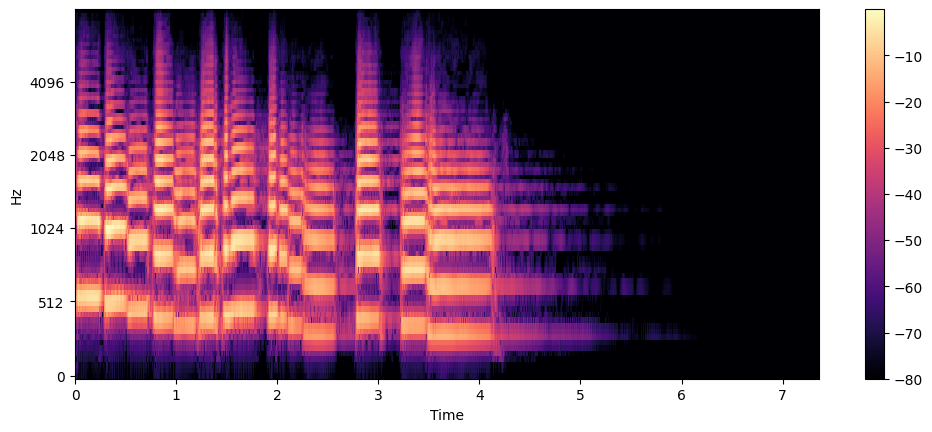

In [5]:
# plot in dB -> make sure to pass constants to display func (see https://librosa.org/doc/main/generated/librosa.display.specshow.html)
plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=16000, hop_length=hop_length, n_fft=n_fft)
plt.colorbar();

### Whisper

The Whisper feature extractor performs two operations:
1. Pads the input audio samples to a fixed length (30s)
2. Computes the log-mel spectrograms

Whisper pads to a fixed length since it **does not** use an attention mask on the inputs - it relies on padding all input values shorter than 30s with zeros (silence) to a fixed length. Inputs longer than 30s are truncated to a fixed length.

In [6]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [7]:
# this is the attribute that defines our fixed input length -> we always pad/truncate our inputs to this length (in seconds)
feature_extractor.chunk_length

30

In [8]:
# resample the audio input if necessary
if sampling_rate != feature_extractor.sampling_rate:
    array = librosa.resample(array, orig_sr=sampling_rate, target_sr=feature_extractor.sampling_rate)

In [9]:
# get Whisper log-mel features: note that we can pass the argument `return_tensors="np"` to get numpy arrays out
input_features = feature_extractor(array, sampling_rate=feature_extractor.sampling_rate, return_tensors="np").input_features[0]

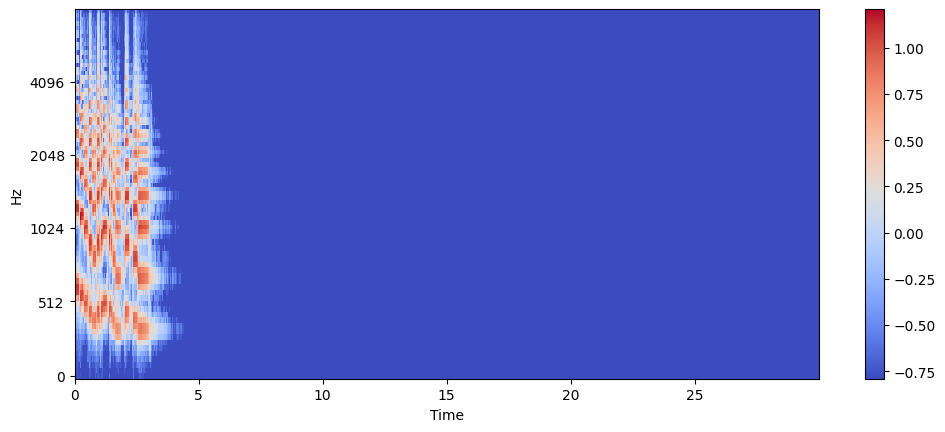

In [10]:
plt.figure().set_figwidth(12)
librosa.display.specshow(input_features, x_axis='time', y_axis='mel', sr=16000, hop_length=hop_length, n_fft=n_fft)
plt.colorbar();

Alright! We see now that our x-axis scale matches up with our librosa plot! Since librosa isn't doing any padding, it only computes the log-mel spectrograms for the length of the audio input (~7s). On the other hand, Whisper also computes the spectrograms for the padded audio input (7s -> 30s). If we want to match our Whisper plot to the librosa one, we can slice the Whisper features for the audio >7s:

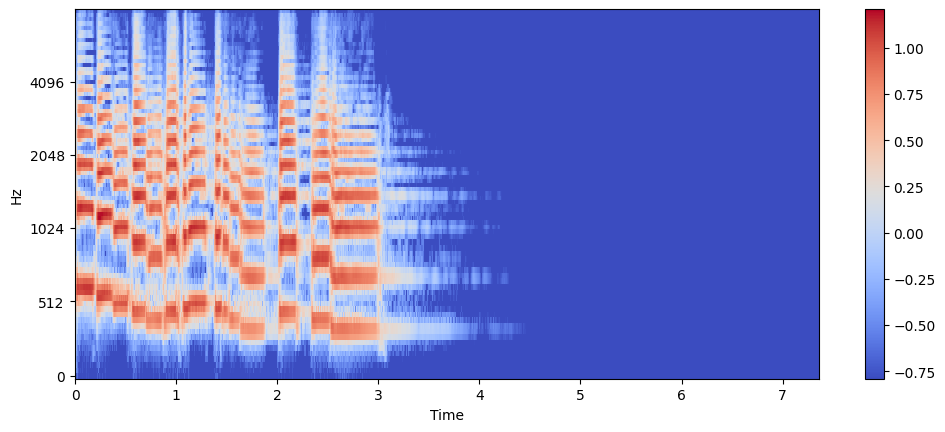

In [14]:
sliced_features = input_features[:, :len(S_dB[0])]

plt.figure().set_figwidth(12)
librosa.display.specshow(sliced_features, x_axis='time', y_axis='mel', sr=16000, hop_length=hop_length, n_fft=n_fft)
plt.colorbar();

Now for the y-axis! The Whisper feature extractor by-and-large performs a standard log-mel extraction. This is what we apply to the input audios up to [L210](https://github.com/huggingface/transformers/blob/f7329751fe5c43365751951502c00df5a4654359/src/transformers/models/whisper/feature_extraction_whisper.py#L210) in the feature extraction code. The array `mel_spec` is largely the same array as our librosa one `S`!

We then perform three additional operations:
1. take log10
2. do a max op
3. normalise

We can perform the inverse of the first and third of these ops to try and recover the `mel_spec` array:

In [24]:
class LibrosaEquivalentFeatureExtractor(WhisperFeatureExtractor):
    def __init__(
        self,
        feature_size=80,
        sampling_rate=16000,
        hop_length=160,
        chunk_length=30,
        n_fft=400,
        padding_value=0.0,
        return_attention_mask=False,  # pad inputs to max length with silence token (zero) and no attention mask
        **kwargs,
    ):
        super().__init__(
            feature_size=feature_size,
            sampling_rate=sampling_rate,
            hop_length=hop_length,
            chunk_length=chunk_length,
            n_fft=n_fft,
            padding_value=padding_value,
            return_attention_mask=return_attention_mask,
            **kwargs,
        )
    def _np_extract_fbank_features(self, waveform):
        """
        Compute the log-Mel spectrogram of the provided audio, gives similar results whisper's original torch
        implementation with 1e-5 tolerance.
        """
        window = np.hanning(self.n_fft + 1)[:-1]

        frames = self.fram_wave(waveform)
        stft = self.stft(frames, window=window)
        magnitudes = np.abs(stft[:, :-1]) ** 2

        filters = self.mel_filters
        mel_spec = filters @ magnitudes
        
        return mel_spec

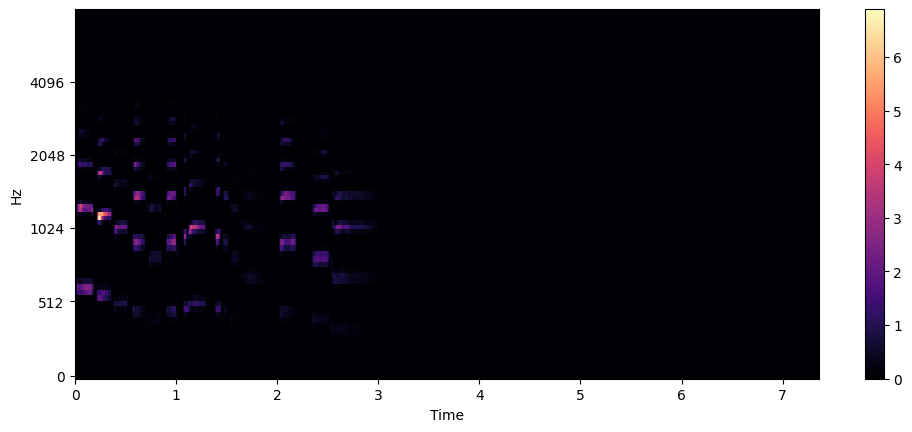

In [31]:
feature_extractor = LibrosaEquivalentFeatureExtractor.from_pretrained("openai/whisper-small")

input_features = feature_extractor(array, sampling_rate=feature_extractor.sampling_rate, return_tensors="np").input_features[0]

sliced_features = input_features[:, :len(S[0])]

# plot
plt.figure().set_figwidth(12)
librosa.display.specshow(sliced_features, x_axis='time', y_axis='mel', sr=16000, hop_length=hop_length, n_fft=n_fft)
plt.colorbar();

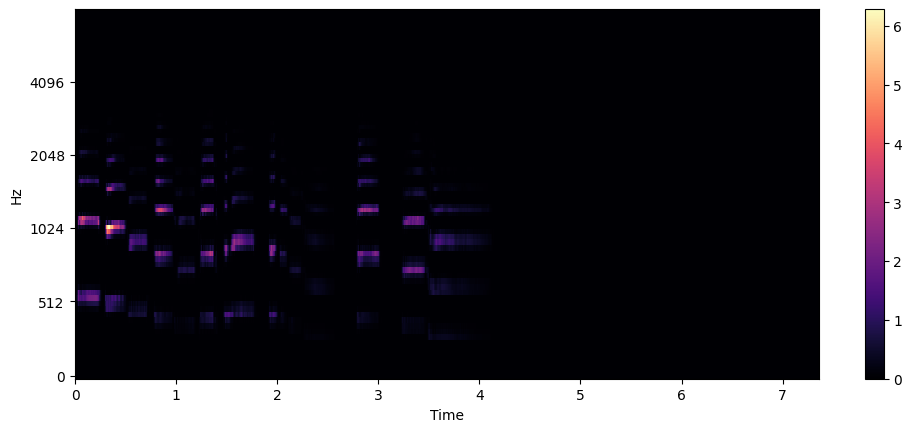

In [32]:
plt.figure().set_figwidth(12)
librosa.display.specshow(S, x_axis='time', y_axis='mel', sr=16000, hop_length=hop_length, n_fft=n_fft)
plt.colorbar();

More or less the same -> differences come from how we compute the filter coeffs most likely (see [get_mel_features](https://github.com/huggingface/transformers/blob/f7329751fe5c43365751951502c00df5a4654359/src/transformers/models/whisper/feature_extraction_whisper.py#L86)) and how we window